# Proyecto Integrador: Análisis de Calidad de Sueño

## Objetivo
El objetivo de este proyecto es predecir la **Duración del Sueño (`Sleep Duration`)** basándose en diversas características de estilo de vida y salud, como la actividad física, el estrés, la categoría de BMI y la presión arterial. Utilizaremos modelos de **Regresión Lineal** y técnicas de regularización (**Lasso, Ridge, ElasticNet**) para encontrar el mejor modelo predictivo.

---

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Configuración de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Proyecto Integrador: Análisis de Calidad de Sueño

## 1. Introducción

### 1.1 Origen de los Datos
El conjunto de datos utilizado es el **Sleep Health and Lifestyle Dataset** obtenido de Kaggle. Este dataset comprende 400 filas y 13 columnas, cubriendo una amplia gama de variables relacionadas con el sueño y los hábitos diarios.

### 1.2 Descripción del Dataset
El dataset incluye detalles sobre hábitos de sueño, estilo de vida y salud cardiovascular. 
- **Total de Registros:** ~400 filas.
- **Variables Predictoras (Inputs):**
    1. `Gender`: Género de la persona (Male/Female).
    2. `Age`: Edad de la persona en años.
    3. `Occupation`: Ocupación o profesión.
    4. `Physical Activity Level`: Minutos de actividad física diaria.
    5. `Stress Level`: Nivel subjetivo de estrés (escala 1-10).
    6. `BMI Category`: Categoría de Índice de Masa Corporal (e.g., Normal, Overweight).
    7. `Blood Pressure`: Presión arterial (sistólica/diastólica).
    8. `Heart Rate`: Frecuencia cardíaca en reposo (bpm).
    9. `Daily Steps`: Número de pasos diarios.
    10. `Sleep Disorder`: Trastorno del sueño diagnosticado (None, Insomnia, Sleep Apnea).
- **Variable Objetivo (Target):**
    1. `Sleep Duration`: Duración del sueño en horas por día.

### 1.3 Definición del Problema
El objetivo es construir un modelo de regresión que pueda estimar la **duración del sueño** de una persona en función de sus características biológicas y de estilo de vida. Entender estos factores es crucial para identificar hábitos que promuevan una mejor higiene del sueño.

### 1.4 Justificación de la Técnica
Dado que `Sleep Duration` es una variable **numérica continua**, la **Regresión Lineal** es una técnica adecuada para modelar la relación entre los predictores y el objetivo, permitiéndonos cuantificar el impacto de cada variable (e.g., cuánto disminuye el sueño por cada punto extra de estrés).

---
## 2. Carga y Exploración de Datos


In [26]:
# Cargar el dataset
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

# Vista inicial
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [27]:
# Información general
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    str    
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    str    
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    str    
 9   Blood Pressure           374 non-null    str    
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    str    
dtypes: float64(1), int64(7), str(5)
memory usage: 38.1 KB


In [28]:
# Estadísticas descriptivas
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


## 2. Limpieza y Preprocesamiento de Datos

### Tratamiento de Valores Nulos y Columnas Especiales
1. **`Sleep Disorder`**: Los valores nulos indican que la persona no tiene trastorno de sueño. Los reemplazaremos por "None".
2. **`Blood Pressure`**: Esta columna contiene dos valores (Sistólica/Diastólica) en formato string (ej. "126/83"). La dividiremos en dos columnas numéricas: `BP_Systolic` y `BP_Diastolic`.
3. **Eliminación de columnas irrelevantes**: `Person ID`.

In [29]:
# 1. Tratar Sleep Disorder
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# 2. Dividir Blood Pressure
df[['BP_Systolic', 'BP_Diastolic']] = df['Blood Pressure'].str.split('/', expand=True)
df['BP_Systolic'] = pd.to_numeric(df['BP_Systolic'])
df['BP_Diastolic'] = pd.to_numeric(df['BP_Diastolic'])

# 3. Eliminar columnas originales/irrelevantes
df = df.drop(columns=['Person ID', 'Blood Pressure'])

# Verificar cambios
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,BP_Systolic,BP_Diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


## 3. Análisis Exploratorio de Datos (EDA)

### Variable Objetivo: `Sleep Duration`

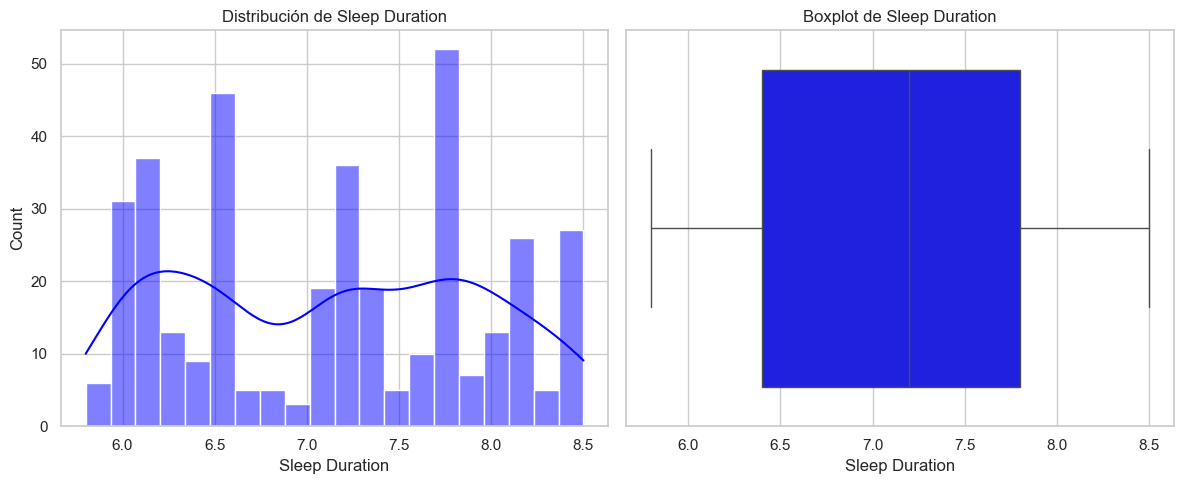

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Sleep Duration'], bins=20, kde=True, color='blue')
plt.title('Distribución de Sleep Duration')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Sleep Duration'], color='blue')
plt.title('Boxplot de Sleep Duration')

plt.tight_layout()
plt.show()

### Interpretación de la Distribución
El histograma muestra cómo se distribuye la duración del sueño en nuestra muestra. 
- Si la distribución se asemeja a una **campana de Gauss (Normal)**, los modelos lineales suelen funcionar mejor.
- Observamos si hay **sesgo** (colas hacia la derecha o izquierda) o valores atípicos que puedan distorsionar el modelo.

### Matriz de Correlación
Analizamos la relación entre las variables numéricas.

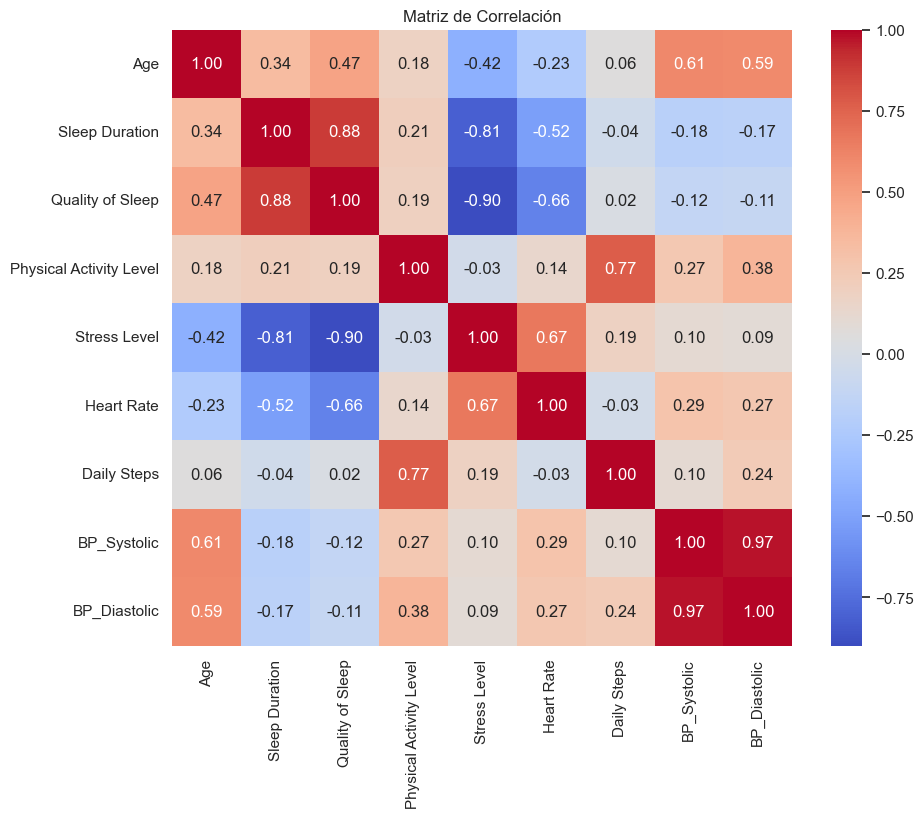

In [31]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

### Interpretación de la Correlación
El mapa de calor nos revela las relaciones lineales entre variables numéricas:
- **Correlación Positiva (Rojo/Naranja)**: Cuando una variable aumenta, la otra también (ej. `Quality of Sleep` y `Sleep Duration` suelen estar correlacionados).
- **Correlación Negativa (Azul)**: Cuando una variable aumenta, la otra disminuye (ej. `Stress Level` suele tener correlación negativa con `Sleep Duration`).
- **Multicolinealidad**: Si dos variables predictoras tienen una correlación muy alta (cercana a 1 o -1), podrían confundir al modelo. (ej. `Systolic` y `Diastolic` BP suelen estar muy correlacionadas).

## 4. Preparación para el Modelado

### Encoding de Variables Categóricas
Utilizaremos One-Hot Encoding para las variables categóricas: `Gender`, `Occupation`, `BMI Category`, `Sleep Disorder`.

In [32]:
# One-Hot Encoding
df_processed = pd.get_dummies(df, drop_first=True)

print("Shape del dataset procesado:", df_processed.shape)
df_processed.head()

Shape del dataset procesado: (374, 25)


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,BP_Systolic,BP_Diastolic,Gender_Male,...,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder_None,Sleep Disorder_Sleep Apnea
0,27,6.1,6,42,6,77,4200,126,83,True,...,False,False,False,True,False,False,False,True,True,False
1,28,6.2,6,60,8,75,10000,125,80,True,...,False,False,False,False,False,False,False,False,True,False
2,28,6.2,6,60,8,75,10000,125,80,True,...,False,False,False,False,False,False,False,False,True,False
3,28,5.9,4,30,8,85,3000,140,90,True,...,True,False,False,False,False,False,True,False,False,True
4,28,5.9,4,30,8,85,3000,140,90,True,...,True,False,False,False,False,False,True,False,False,True


### División Train/Test y Escalado

In [33]:
# Definir X e y
X = df_processed.drop(columns=['Sleep Duration'])
y = df_processed['Sleep Duration']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Implementación de Modelos de Regresión

Probaremos 4 modelos:
1. **Regresión Lineal** (Base)
2. **Lasso (L1)** (Selección de características)
3. **Ridge (L2)** (Manejo de multicolinealidad)
4. **ElasticNet** (Combinación L1+L2)

In [34]:
# Inicializar modelos
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# Diccionario para guardar resultados
results = {}

for name, model in models.items():
    # Entrenar
    model.fit(X_train_scaled, y_train)
    
    # Predecir
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Evaluar
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'R2 Train': r2_train,
        'R2 Test': r2_test
    }
    
    print(f"--- {name} ---")
    print(f"RMSE Test: {rmse_test:.4f}")
    print(f"R2 Test: {r2_test:.4f}")
    print("-"*30)

--- Linear Regression ---
RMSE Test: 0.2726
R2 Test: 0.8883
------------------------------
--- Lasso ---
RMSE Test: 0.3923
R2 Test: 0.7688
------------------------------
--- Ridge ---
RMSE Test: 0.2788
R2 Test: 0.8832
------------------------------
--- ElasticNet ---
RMSE Test: 0.3360
R2 Test: 0.8304
------------------------------


## 6. Comparación de Resultados

In [35]:
# Crear DataFrame de resultados
results_df = pd.DataFrame(results).T
results_df

,RMSE Train,RMSE Test,R2 Train,R2 Test
Linear Regression,0.233992,0.272642,0.911669,0.888349
Lasso,0.369499,0.392344,0.779739,0.768789
Ridge,0.236266,0.278822,0.909944,0.883230
ElasticNet,0.322173,0.336001,0.832548,0.830427


<Figure size 1000x500 with 0 Axes>

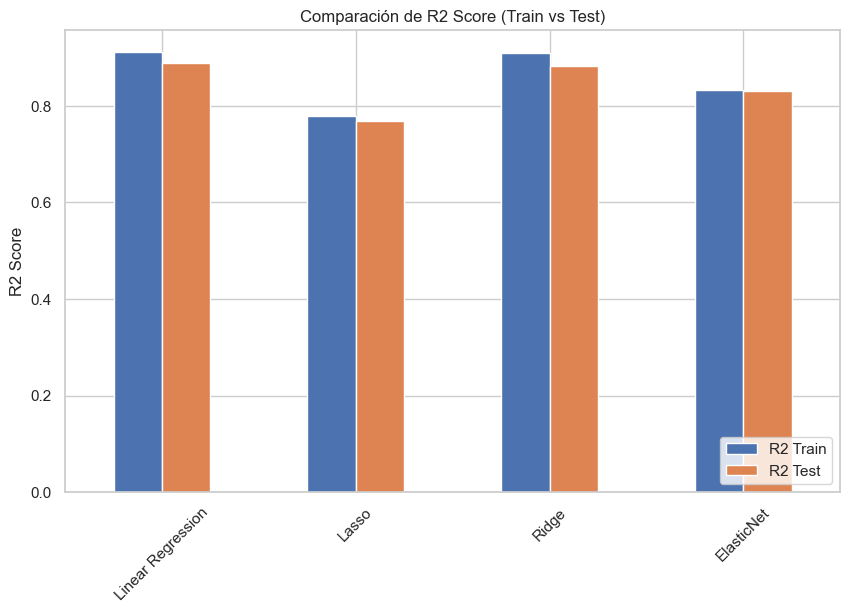

In [36]:
# Visualizar R2 Score
plt.figure(figsize=(10, 5))
results_df[['R2 Train', 'R2 Test']].plot(kind='bar')
plt.title('Comparación de R2 Score (Train vs Test)')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

### 6.1 Análisis Gráfico de Resultados

Visualizaremos el desempeño del mejor modelo para entender mejor sus predicciones.

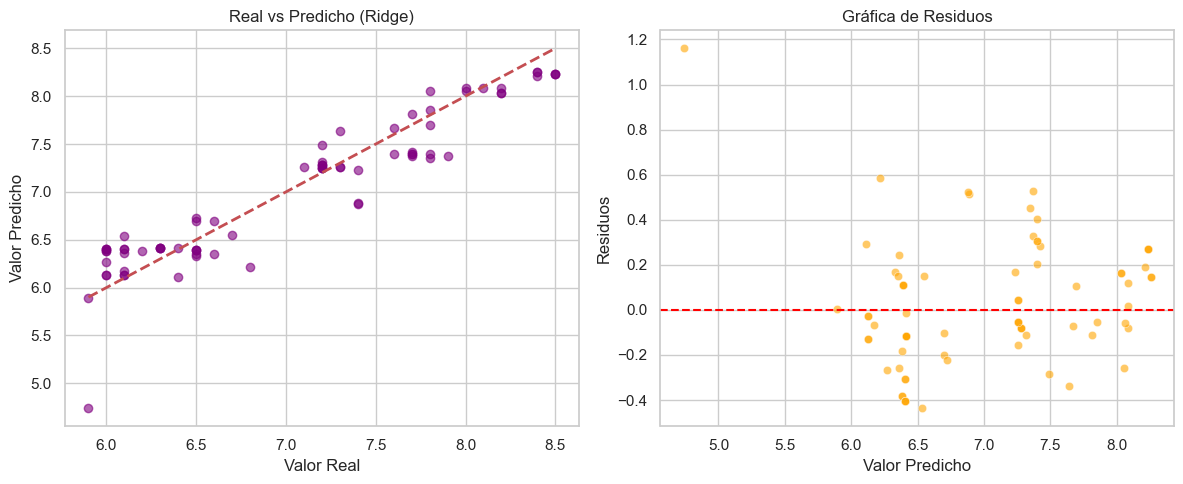

In [37]:
# SCATTER PLOT: REAL VS PREDICHO
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos el mejor modelo (Ridge)
best_model_name = 'Ridge'
if best_model_name in models:
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test_scaled)

    plt.figure(figsize=(12, 5))

    # 1. Real vs Predicho
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_best, alpha=0.6, color='purple')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Predicho')
    plt.title(f'Real vs Predicho ({best_model_name})')

    # 2. Residuos
    residuals = y_test - y_pred_best
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred_best, y=residuals, color='orange', alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Valor Predicho')
    plt.ylabel('Residuos')
    plt.title('Gráfica de Residuos')

    plt.tight_layout()
    plt.show()
else:
    print(f"Modelo {best_model_name} no encontrado en 'models'.")

### Interpretación de los Resultados Gráficos

1.  **Gráfica Real vs Predicho**:
    *   **Ideal**: Todos los puntos deberían caer sobre la línea roja punteada (diagonal).
    *   **Observación**: Si los puntos están muy dispersos alrededor de la línea, el modelo tiene un error considerable. Si siguen la tendencia, el modelo ha capturado bien el patrón general.

2.  **Gráfica de Residuos**:
    *   **Ideal**: Los puntos (residuos) deben estar distribuidos aleatoriamente alrededor de la línea roja horizontal (0), sin formar patrones claros (como una "U" o un embudo).
    *   **Observación**: Si vemos una distribución aleatoria, asumimos que el modelo es válido (**Homocedasticidad**). Si hay patrones, podría indicar que faltan variables o que la relación no es totalmente lineal.

---

C:\Users\nixle\AppData\Local\Temp\ipykernel_24300\1682327600.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


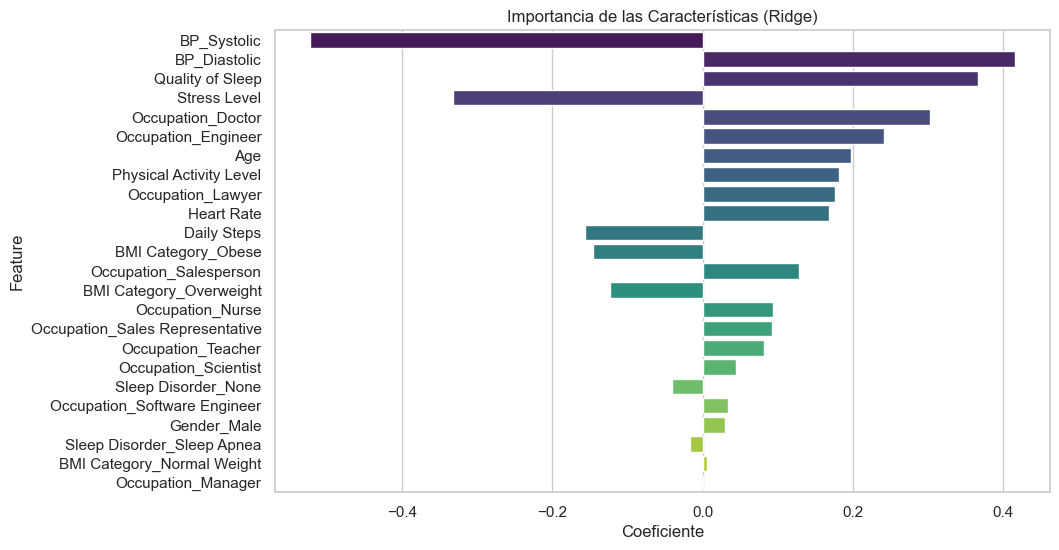

In [38]:
# FEATURE IMPORTANCE
if 'best_model' in locals():
    feature_names = X.columns
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': best_model.coef_
    })
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
    plt.title(f'Importancia de las Características ({best_model_name})')
    plt.xlabel('Coeficiente')
    plt.show()

### Interpretación de Coeficientes
Esta gráfica nos muestra **qué variables influyen más** en la duración del sueño según el modelo:
*   **Barras Grandes (Positivas)**: Factores que *aumentan* el sueño. (e.g., Si `Physical Activity` es alta y positiva, hacer ejercicio ayuda a dormir más).
*   **Barras Grandes (Negativas)**: Factores que *disminuyen* el sueño. (e.g., Si `Stress Level` es muy negativo, más estrés significa menos sueño).
*   **Cercanas a Cero**: Variables que no aportan mucha información al modelo para predecir el sueño.

## 7. Conclusiones

Basado en los resultados anteriores, podemos concluir:
1. **Rendimiento General**: [Observar el R2 más alto]
2. **Overfitting**: [Observar diferencia entre Train y Test]
3. **Mejor Modelo**: [Seleccionar el modelo con menor RMSE y mayor R2 en Test]

Este dataset, al tener variables más correlacionadas con la salud física y el estilo de vida, debería mostrar un mejor ajuste lineal que el dataset de noticias anterior.